In [1]:
import lzma
import pickle
import matplotlib.pyplot as plt
import numpy as np
from multireward_ope.tabular.envs.make_env import make_env
from multireward_ope.tabular.reward_set import RewardSetRewardFree
import preamble_figures
import pandas as pd
import seaborn as sns
from multireward_ope.tabular.dataclasses import Config
from multireward_ope.tabular.agents.make_agent import make_agent
from multireward_ope.tabular.agents.dataclasses import AgentParameters


def get_values(cfg: Config) -> np.ndarray:
    env = make_env(cfg.environment)
    policy_to_eval = env.default_policy(cfg.experiment.discount_factor)
    reward_set = RewardSetRewardFree(env.dim_state, env.dim_action, 
                                        RewardSetRewardFree.RewardSetFreeConfig())
    eval_rewards = reward_set.canonical_rewards()
    NUM_REWARDS = eval_rewards.shape[0]
    rewards = np.zeros((NUM_REWARDS, env.dim_state, env.dim_action))
    values = np.zeros((NUM_REWARDS, env.dim_state))
    for i in range(NUM_REWARDS):
        rewards[i, np.arange(env.dim_state), policy_to_eval] = eval_rewards[i]
        values[i] = env.policy_evaluation(rewards[i], cfg.experiment.discount_factor, policy_to_eval)
    return values

In [4]:
data = []
HORIZON = 300000

for env, N in [('Riverswim',30),('ForkedRiverswim',15),('DoubleChain',31),('NArms',30)]:
    for agent in ['Noisy-Policy_Uniform_0.3', 
                'Noisy-Policy_Visitation based_0.15',
                'MR-NaS-PE_500_False']:

        filename = f'{HORIZON}_{env}_{N}_{agent}.lzma'
        with lzma.open(f'./data/tabular/{filename}', 'rb') as f:
            res = pickle.load(f)
            values = get_values(res['cfg'])
            err_rel = res['results'] / values.max(-1,keepdims=True)[None,None,...]
            errors = np.linalg.norm(err_rel, ord=np.inf, axis=-1).max(-1)[:,-1]
            for error in errors:
                data.append({'Environment': env, 'Agent': AgentParameters.short_name(res['cfg'].agent), 'Error': error})

df = pd.DataFrame(data)

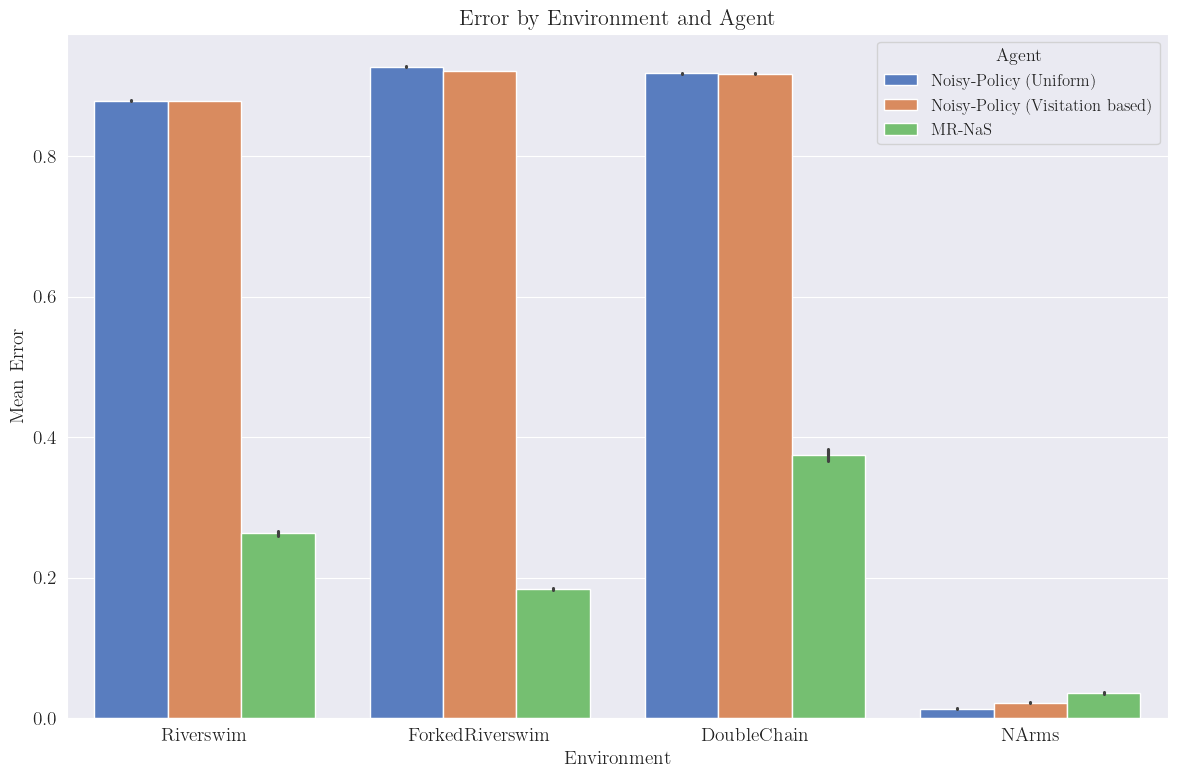

In [5]:
# Step 2: Plot with Seaborn
# sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(
    x='Environment',
    y='Error',
    hue='Agent',
    data=df,
    errorbar=('ci', 95),
    # capsize=0.2,
    palette='muted'
)

bar_plot.set_title('Error by Environment and Agent', fontsize=16)
bar_plot.set_xlabel('Environment', fontsize=14)
bar_plot.set_ylabel('Mean Error', fontsize=14)
plt.legend(title='Agent', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

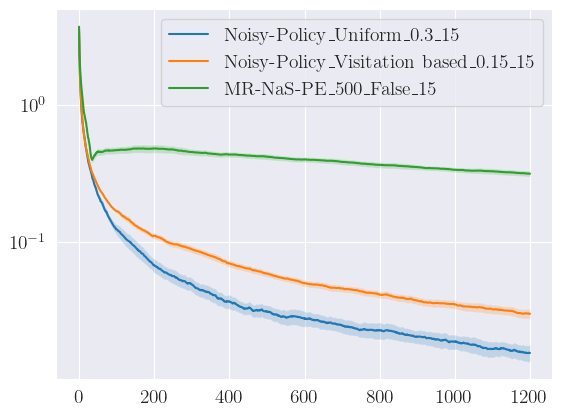

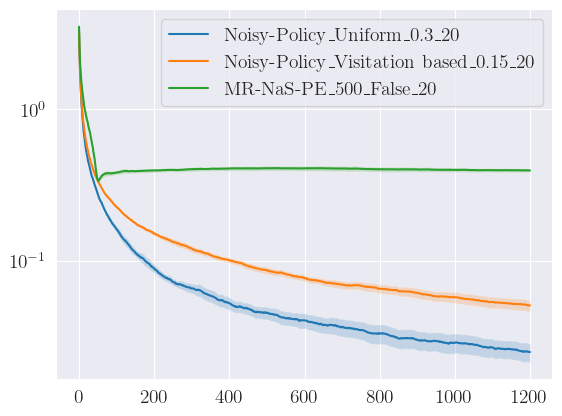

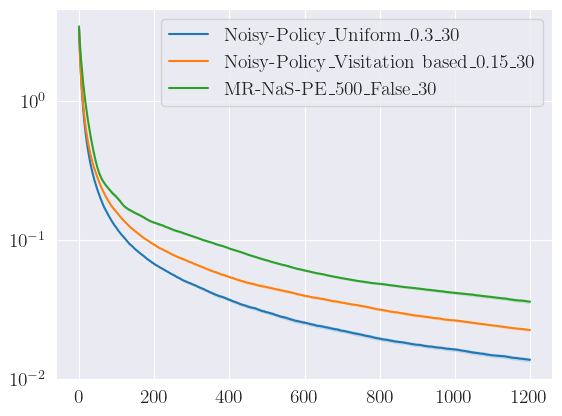

In [2]:

for horizon in [300000]:
    for num_states in [15,20,30]:
        plt.figure()
        results = []
        
        for agent in ['Noisy-Policy_Uniform_0.3', 
                      'Noisy-Policy_Visitation based_0.15',
                      'MR-NaS-PE_500_False']:

            filename = f'{horizon}_NArms_{num_states}_{agent}.lzma'
            with lzma.open(f'./data/tabular/{filename}', 'rb') as f:
                res = pickle.load(f)
                results.append((agent, res))

        
        for agent_name, res in results:
            values = get_values(res['cfg'])
            err_rel = res['results'] / values.max(-1,keepdims=True)[None,None,...]
            errors = np.linalg.norm(err_rel, ord=np.inf, axis=-1).max(-1)
            xvalues = np.arange(errors.shape[1])
            mu = errors.mean(0)
            ce = 1.96*errors.std(0, ddof=-1) / np.sqrt(errors.shape[0])
            plt.plot(xvalues, mu, label=agent_name + f'_{num_states}')
            plt.fill_between(xvalues, mu-ce, mu+ce, alpha=0.2)

        plt.yscale('log')
        plt.legend()

In [14]:
values.max(-1)

array([ 1.51237046,  1.51099221,  1.51091047,  1.51090573,  1.51090547,
        1.51090546,  1.51090547,  1.51090568,  1.51090999,  1.51116294,
        1.51679657,  1.61165893,  3.2090262 , 30.10563853, 69.00184319])

In [12]:
res['results'].mean(0)[-1]

array([[-0.01026615, -0.01082859, -0.01010526, -0.01002183, -0.00995998,
        -0.0098513 , -0.00967273, -0.00941369, -0.00922762, -0.00910017,
        -0.00901786, -0.00896862, -0.00894459, -0.00893657, -0.00893647],
       [-0.01650344, -0.01823468, -0.01961871, -0.0193587 , -0.01922526,
        -0.0190147 , -0.01867171, -0.01817406, -0.01781661, -0.01757179,
        -0.01741367, -0.01731908, -0.01727294, -0.01725753, -0.01725733],
       [-0.02417877, -0.02588116, -0.02795852, -0.02865795, -0.02837637,
        -0.02804443, -0.02754064, -0.02680778, -0.02628149, -0.02592102,
        -0.02568821, -0.02554893, -0.02548098, -0.02545829, -0.02545799],
       [-0.02976455, -0.03140888, -0.03340148, -0.03574516, -0.03743736,
        -0.03685028, -0.03622312, -0.0352597 , -0.03456803, -0.03409431,
        -0.03378835, -0.0336053 , -0.03351602, -0.03348621, -0.03348582],
       [-0.03725285, -0.03887051, -0.04081286, -0.04307575, -0.04574113,
        -0.04483915, -0.0447924 , -0.0436102 , 

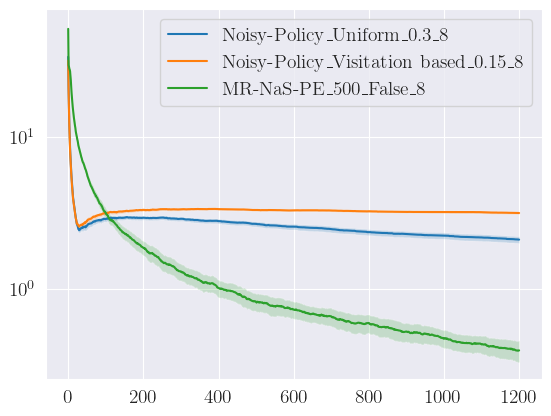

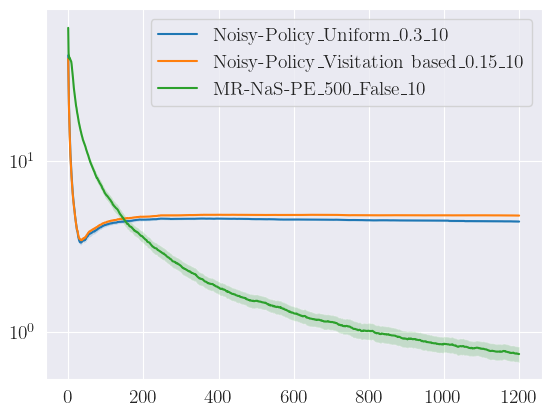

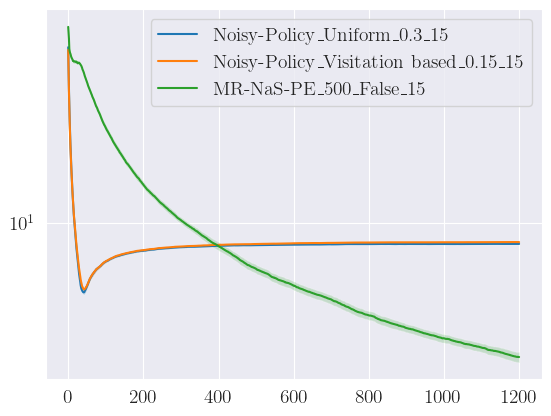

In [3]:

for horizon in [300000]:
    for num_states in [8,10,15]:#,20,30]:
        plt.figure()
        results = []
        
        for agent in ['Noisy-Policy_Uniform_0.3', 
                      'Noisy-Policy_Visitation based_0.15',
                      #'MR-NaS-PE_500_False',
                      'MR-NaS-PE_500_False']:

            filename = f'{horizon}_ForkedRiverswim_{num_states}_{agent}.lzma'
            with lzma.open(f'./data/tabular/{filename}', 'rb') as f:
                res = pickle.load(f)
                results.append((agent, res))

        for agent_name, res in results:
            errors = np.linalg.norm(res['results'], ord=np.inf, axis=-1).max(-1)
            xvalues = np.arange(errors.shape[1])
            mu = errors.mean(0)
            ce = 1.96*errors.std(0, ddof=-1) / np.sqrt(errors.shape[0])
            plt.plot(xvalues, mu, label=agent_name + f'_{num_states}')
            plt.fill_between(xvalues, mu-ce, mu+ce, alpha=0.2)

        plt.yscale('log')
        plt.legend()